# CLIP on BUSI Breast Ultrasound Dataset


In [1]:
# Imports
import os
import torch
import clip
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Custom BUSI Dataset Loader

In [3]:
class BreastUltrasoundDataset(Dataset):
    """Custom Dataset for Breast Ultrasound Images."""
    def __init__(self, image_dir, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform
        self.class_names = ["normal", "benign", "malignant"]
        samples = []
        for idx, class_name in enumerate(self.class_names):
            class_folder = os.path.join(image_dir, class_name)
            image_files = [f for f in os.listdir(class_folder) if f.lower().endswith('.png')]
            for filename in image_files:
                samples.append((os.path.join(class_folder, filename), idx))
        if max_samples is not None:
            samples = samples[:max_samples]
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

## Data Preparation

In [ ]:
# Paths and class names
image_root_dir = "./data/Dataset_BUSI_with_GT" 
class_names = ["normal", "benign", "malignant"]

# CLIP preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Load dataset and split
full_dataset = BreastUltrasoundDataset(image_root_dir, transform=preprocess)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Train/val split: {len(train_dataset)}/{len(val_dataset)}")

Train/val split: 1262/316


## Load CLIP Model

In [5]:
model_name = "ViT-B/32"
clip_model, _ = clip.load(model_name, device=device)
clip_model.eval()
print(f"Loaded CLIP: {model_name}")

Loaded CLIP: ViT-B/32


## Zero-Shot Evaluation (CLIP Only)

In [6]:
def evaluate_clip_on_dataset(model, dataloader, class_names):
    correct = 0
    total = 0
    prompts = [f'an ultrasound image of {c} breast tissue' for c in class_names]
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]
            chunk_size = 2
            all_predictions = []
            for i in range(0, batch_size, chunk_size):
                chunk_images = images[i:i+chunk_size]
                chunk_image_features = model.encode_image(chunk_images)
                chunk_image_features /= chunk_image_features.norm(dim=-1, keepdim=True)
                chunk_similarity = chunk_image_features @ text_features.T
                _, chunk_predicted = chunk_similarity.max(1)
                all_predictions.extend(chunk_predicted.tolist())
            predictions = torch.tensor(all_predictions, device=device)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Zero-shot accuracy: {accuracy:.2f}%")
    return accuracy

clip_zeroshot_acc = evaluate_clip_on_dataset(clip_model, val_loader, class_names)

Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]

Zero-shot accuracy: 21.52%


## Fine-Tuning: Linear Layer on CLIP Visual Features

In [7]:
class CLIPFineTuner:
    """Fine-tuning class for BUSI/CLIP."""
    def __init__(self, clip_model, class_count, learning_rate=1e-3):
        self.clip_model = clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False
        feature_dim = clip_model.visual.output_dim
        self.classifier = nn.Linear(feature_dim, class_count).to(device)
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
    def train_step(self, images, labels):
        self.optimizer.zero_grad()
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        logits = self.classifier(image_features)
        loss = self.loss_fn(logits, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    def train_epoch(self, dataloader):
        self.clip_model.eval()
        self.classifier.train()
        total_loss, correct, total_samples, batch_count = 0, 0, 0, 0
        for images, labels in tqdm(dataloader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            loss = self.train_step(images, labels)
            total_loss += loss
            with torch.no_grad():
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
            batch_count += 1
        avg_loss = total_loss / batch_count
        train_acc = 100 * correct / total_samples
        return avg_loss, train_acc
    def evaluate(self, dataloader):
        self.clip_model.eval()
        self.classifier.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        accuracy = 100 * correct / total
        print(f"Fine-tuned accuracy: {accuracy:.2f}%")
        return accuracy

## Run Training & Evaluation

In [ ]:
layer_names = [name for name, _ in tuner.classifier.named_parameters()]
num_layers = len(layer_names)
num_epochs = 3 
layerwise_grads = np.zeros((num_layers, num_epochs))
for epoch in range(epochs):
    train_loss, train_acc = tuner.train_epoch(train_loader)
    grads = []
    for idx, (name, param) in enumerate(tuner.classifier.named_parameters()):
        if param.grad is not None:
            grads.append(param.grad.detach().abs().mean().cpu().item())
        else:
            grads.append(0.0)
        layerwise_grads[idx, epoch] = grads[-1]
    val_acc = tuner.evaluate(val_loader)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 4))
im = plt.imshow(layerwise_grads, aspect='auto', cmap='hot')
plt.colorbar(im, label='Mean Gradient')
plt.xticks(range(num_epochs), [f'Epoch {i+1}' for i in range(num_epochs)])
plt.yticks(range(num_layers), layer_names)
plt.xlabel('Epoch')
plt.ylabel('Layer')
plt.title('Layer-wise Mean Gradients Over Epochs')
plt.tight_layout()
plt.show()

In [8]:
epochs = 3
tuner = CLIPFineTuner(clip_model, len(class_names))

losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = tuner.train_epoch(train_loader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
    val_acc = tuner.evaluate(val_loader)
    losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Epoch 1/3


Training: 100%|██████████| 316/316 [02:13<00:00,  2.38it/s]


Train loss: 0.6129 | Train acc: 75.99%


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


Fine-tuned accuracy: 84.49%

Epoch 2/3


Training: 100%|██████████| 316/316 [02:02<00:00,  2.58it/s]


Train loss: 0.4099 | Train acc: 85.34%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]


Fine-tuned accuracy: 84.49%

Epoch 3/3


Training: 100%|██████████| 316/316 [02:08<00:00,  2.47it/s]


Train loss: 0.3587 | Train acc: 86.61%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.66it/s]

Fine-tuned accuracy: 87.97%


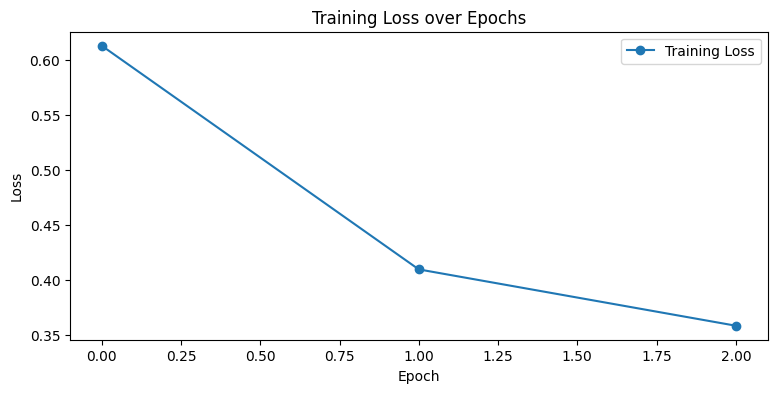

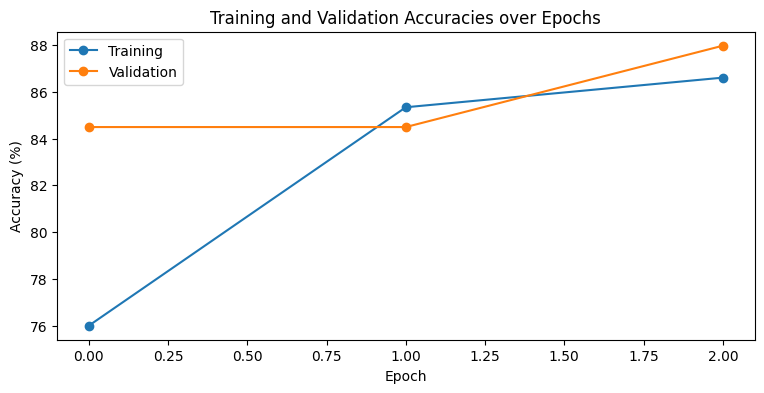

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title('Training Loss over Epochs')
plt.plot(losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(9, 4)
plt.legend(loc='upper right')
plt.show()
plt.figure()
plt.title('Training and Validation Accuracies over Epochs')
plt.plot(train_accuracies, '-o', label='Training Accuracy')
plt.plot(val_accuracies, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Save/Load Model Utility

In [11]:
def save_model(model, optimizer, epoch, path="saved_models/fine_tuned_clip_busi.pt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.classifier.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"Model saved at epoch {epoch + 1} to: {path}")

def load_fine_tuned_model(model, path="saved_models/fine_tuned_clip_busi.pt"):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.classifier.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded fine-tuned model from: {path}")
        return model
    else:
        print(f"No saved model found at: {path}. Ensure the path is correct.")
        return None